<a href="https://colab.research.google.com/github/jungmin0710/K-digital-PythonDeepLearning/blob/main/DC_GAN_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vanilla GAN(Generative Adversarial Network)

In [1]:
import warnings
warnings.filterwarnings('ignore')

## 0.Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, LeakyReLU, Dropout, Input, BatchNormalization 
from keras.layers import Reshape, Conv2D, Conv2DTranspose, Flatten, Activation 
from keras.models import Model,Sequential

## 1.Load MNIST Dataset
* 'generator'의 'tanh' Activation 출력에 적합하도록 정규화


In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Normalization : tanh함수를 사용(-1~1)하기 때문에 사잇값이 되도록 225의 반으로 나눈 후, -1을 해준다
X_train = X_train.astype(np.float32) / 127.5 - 1

#Reshape
X_train = X_train.reshape(-1, 28, 28, 1)

11493376/11490434 [==============================] - 0s 0us/step


## 2.'adam' Optimizer
* beta_1 : 감쇠율 조정

In [4]:
from keras.optimizers import Adam

adam = Adam(lr = 0.0002, beta_1 = 0.5)


## 3.'generator' Model
* 랜덤 벡터(잠재공간의 랜덤 포인트)를 입력받아 이미지 생성
  * NOISE_DIM : 입력 랜덤 벡터 크기
* 'discriminator'를 속이도록 학습
  * 'Real Image'와 같은 'Fake Image' 생성이 목적

In [5]:
NOISE_DIM = 10

generator = Sequential(name = 'generator')

#노이즈 데이터 입력받아서 fake 결과물을 만들어 내는 모델 레이어 쌓기
generator.add(Dense(256 * 7 * 7, input_shape = (NOISE_DIM,)))
generator.add(LeakyReLU())

# 12544
generator.add(Reshape((7, 7, 256))) 
# (14, 14, 128) 25088 
generator.add(Conv2DTranspose(128, 
                              kernel_size = 3, 
                              strides = 2, 
                              padding = 'same'))
generator.add(BatchNormalization()) 
generator.add(LeakyReLU()) 
# (28, 28, 64) 50176
generator.add(Conv2DTranspose(64, 
                              kernel_size = 3, 
                              strides = 2, 
                              padding = 'same'))
generator.add(BatchNormalization()) 
generator.add(LeakyReLU()) 
# (28, 28, 1)
generator.add(Conv2D(1, kernel_size = 3, padding='same')) 
generator.add(Activation('tanh'))


* Model Summary

In [6]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             137984    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        73

## 4.'discriminator' Model
* 이미지를 입력받아 'Real Image'인지 'generator'가 생성한 'Fake Image'인지 판별
  * 이진분류

In [7]:
from tensorflow.keras.initializers import RandomNormal

#Fake인지 Real인지 판단하는 이진분류를 수행함
discriminator = Sequential(name = 'discriminator')

discriminator.add(Conv2D(32, 
                         kernel_size = 3, 
                         strides = 2, 
                         padding = 'same', 
                         input_shape = (28, 28, 1)))
discriminator.add(LeakyReLU()) 
discriminator.add(Dropout(0.5)) 
discriminator.add(Conv2D(64, 
                         kernel_size = 3, 
                         strides = 2, 
                         padding = 'same'))
discriminator.add(LeakyReLU()) 
discriminator.add(Conv2D(128, 
                         kernel_size = 3, 
                         strides = 2, 
                         padding = 'same'))
discriminator.add(LeakyReLU()) 
discriminator.add(Dropout(0.5)) 
discriminator.add(Flatten() ) 
discriminator.add(Dense(1, activation = 'sigmoid'))

* Model Summary

In [8]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4, 4, 128)       

### 1)'discriminator' Compile
* 학습 설정

In [9]:
discriminator.compile(loss = 'binary_crossentropy', 
                      optimizer = adam)

## 5. 'gan' Model

### 1)'generator','discriminator' 연결
* 'gan'모델에서 'generator'만 학습하도록 설정
  * discriminator.trainable = False

In [10]:
discriminator.trainable = False

gan_input = Input(shape = (NOISE_DIM,))
x = generator(gan_input)
output = discriminator(x)

### 2)'gan' Model




In [11]:
gan = Model(gan_input, output, name = 'gan')

### 3)'gan' Summary

In [12]:
gan.summary()

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
generator (Sequential)       (None, 28, 28, 1)         508161    
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 94721     
Total params: 602,882
Trainable params: 507,777
Non-trainable params: 95,105
_________________________________________________________________


### 4)'gan' Compile
* 학습 설정

In [13]:
gan.compile(loss = 'binary_crossentropy',
            optimizer = adam)

## 6.Define 'get_batches()' Function
* MNIST image batch 생성

In [14]:
def get_batches(data, batch_size):
  batches = []

  for i in range(data.shape[0] // batch_size):
    batch = data[i * batch_size : (i + 1) * batch_size]
    batches.append(batch)
  return np.asarray(batches)

## 7.'visualize_training()' Function

In [15]:
def visualize_training(epoch, d_losses, g_losses): 
  # 오차 시각화
  # plt.figure(figsize=(8, 4))
  # plt.plot(d_losses, label='Discriminator Loss') 
  # plt.plot(g_losses, label='Generatror Loss') 
  # plt.xlabel('Epoch') # plt.ylabel('Loss') 
  # plt.legend() # plt.show()
  # print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_loss)
  
  # 이미지 생성 결과 시각화 
  print('epoch :', epoch) 
  noise = np.random.normal(0, 1, size = (24, NOISE_DIM)) 
  generated_images = generator.predict(noise) 
  generated_images = generated_images.reshape(-1, 28, 28)

  plt.figure(figsize = (8, 4)) 
  
  for i in range(generated_images.shape[0]): 
    plt.subplot(4, 6, i + 1)
    plt.imshow(generated_images[i], interpolation = 'nearest', cmap = 'Greys_r') 
    plt.axis('off') 
  plt.tight_layout() 
  plt.show()

## 8.Define Loss

In [16]:
# loss_function = keras.losses.BinaryCrossentropy()

# train_loss = keras.metrics.BinaryCrossentropy(name = 'train_loss') 
# train_accuracy = keras.metrics.BinaryAccuracy(name = 'train_accuracy')

## 9.Model Training
* 약 25분 
* fit()
  * 'epoch', 'batch_size' 지정
* train_on_batch()
  * 전달 받은 모든 데이터를 사용하여 학습 진행
* 'generator'가 매번 새로운 'Fake Image'를 생성하여 'train_on_batch()' 사용

epoch : 1


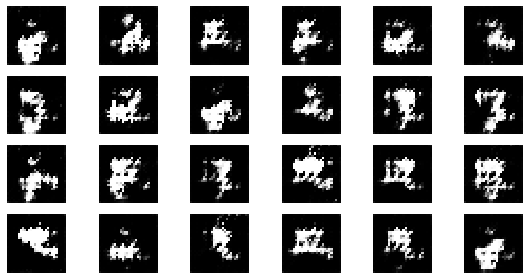

epoch : 5


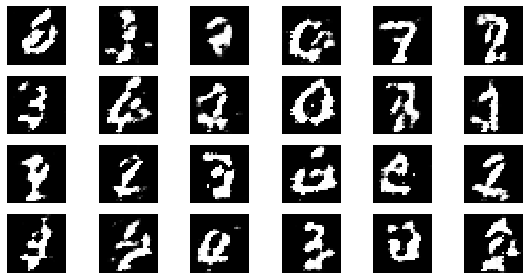

epoch : 10


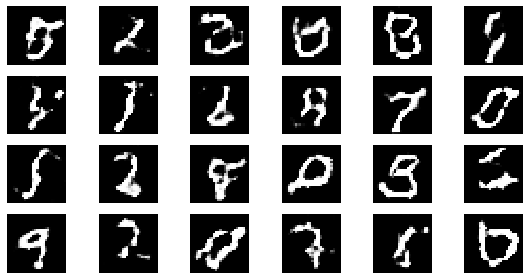

epoch : 15


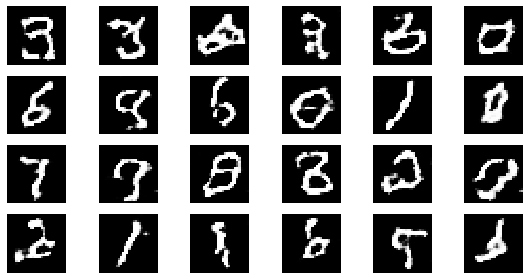

epoch : 20


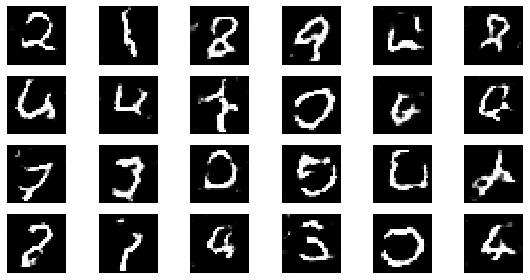

epoch : 25


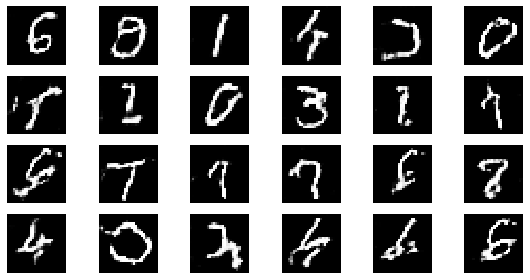

epoch : 30


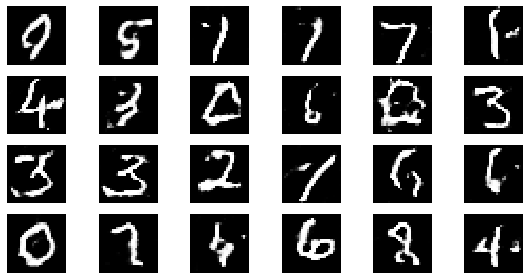

epoch : 35


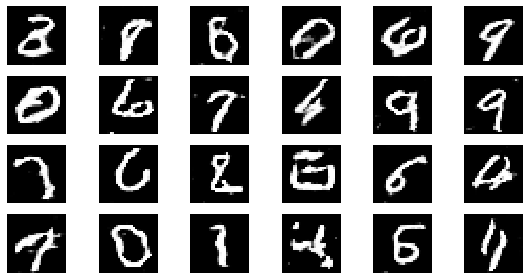

epoch : 40


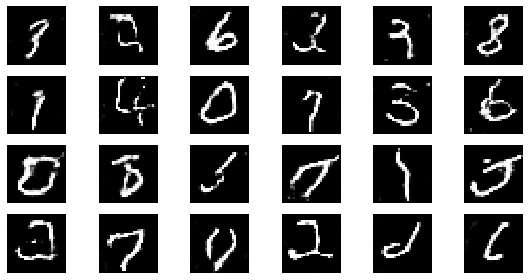

epoch : 45


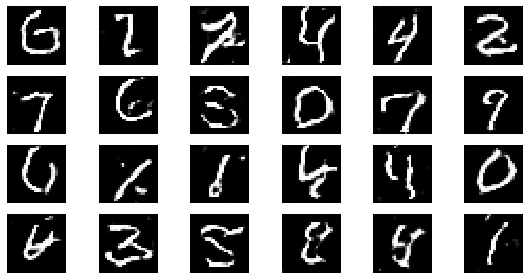

epoch : 50


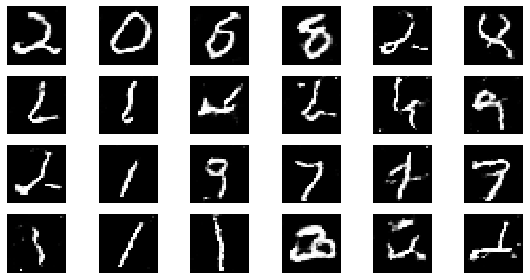

CPU times: user 19min 5s, sys: 1min 14s, total: 20min 20s
Wall time: 24min 30s


In [18]:
%%time

EPOCHS = 50
BATCH_SIZE = 128

# 'discriminator', 'gan' Loss 저장 List 
d_losses = [] 
g_losses = []

for epoch in range(1, EPOCHS + 1): 
  # batch 별 학습 
  for real_images in get_batches(X_train, BATCH_SIZE): 
    # Random Noise 생성
    input_noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM]) 
    
    # Fake Image 데이터 생성
    generated_images = generator.predict(input_noise) 
    
    # 'gan' 학습용 X 데이터 정의
    x_dis = np.concatenate([real_images, generated_images])

    # 'gan' 학습용 y 데이터 정의 
    y_dis = np.zeros(2 * BATCH_SIZE) 
    y_dis[:BATCH_SIZE] = 1
    
    # 'discriminator' 학습 
    discriminator.trainable = True 
    d_loss = discriminator.train_on_batch(x_dis, y_dis)

    # 'gan' 학습
    noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM]) 
    y_gan = np.ones(BATCH_SIZE)

    # 'discriminator' 학습 정지 
    discriminator.trainable = False 
    g_loss = gan.train_on_batch(noise, y_gan)

  d_losses.append(d_loss) 
  g_losses.append(g_loss)
  
  # 생성 결과 시각화 : epoch 5번마다 결과 출력 # 생성 결과 시각화 : epoch 5번마다 결과 출력
  if epoch == 1 or epoch % 5 == 0:
    visualize_training(epoch, d_losses, g_losses)

본 내용은 2021/03/30(화)에 학습한 내용입니다.